Imagine if we had access to the true data distribution $P_{data}(x)$ we could sample from that distribution in order to generate new samples, however there is no direct way to do this as typically this distribution is complex and high-dimensional. What if we could instead sample from a random noise (e.g. Normal distribution) and then learn to transform that to $P_{data}(x)$. Neural networks are a prime candidate to capture functions with high complexity and we can use to to capture this transformation. This is exactly what the do. They train the transformer network or Generator along with another network, called the Discriminator, in a game theoretic way. Going back to our image generation example:

The Generator network ($G$), tries to fool the discriminator in thinking that the generated images are real,meaning that they are taken from $P_{data}$, and
The Discriminator network ($D$), tries to differentiate between real ($x\sim P_{data}$) and fake images.

Random noise is fed into the Generator that transforms it into a "fake image". The Discriminator is fed both from the training set images ($p_{data}(x)$) and the fake images coming from the Generator and it has to tell them apart. The idea behind GAN, is to train both of these networks alternatively to do the best they can in generating and discriminating images. The intuition is that by improving one of these networks, in this game theoretic manner, the other network has to do a better job to win the game, and that in turn improves its performance and this loop continues.

<img src="https://4.bp.blogspot.com/-YTGLQjhch-Q/Wz475NU2TSI/AAAAAAAAsu4/zaC_wfZBX80dePLflgQUaAaxE72od3VCgCEwYBhgL/s1600/Figura_2.png" height="500" width="500">

<pre><b>Credits to Chris Deotte's Kernel</b>
https://www.kaggle.com/cdeotte/dog-memorizer-gan</pre>

<pre><b>Credits to Nanashi's Ideas and Initiatives</b>
https://www.kaggle.com/jesucristo/memorizer-cgan-for-dummies</pre>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.backend import random_normal,ones_like,zeros_like,mean
from keras.backend import get_session
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import concatenate
from keras.initializers import TruncatedNormal
from keras.callbacks import LearningRateScheduler, EarlyStopping, History
from PIL import Image
import warnings
import os
import time
from glob import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from glob import glob

Using TensorFlow backend.


In [2]:
print(os.listdir("../input/"))

['all-dogs', 'annotation']


# Load Images

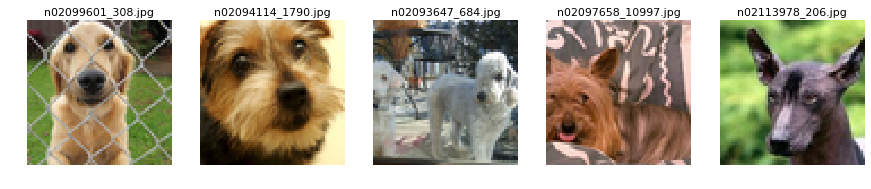

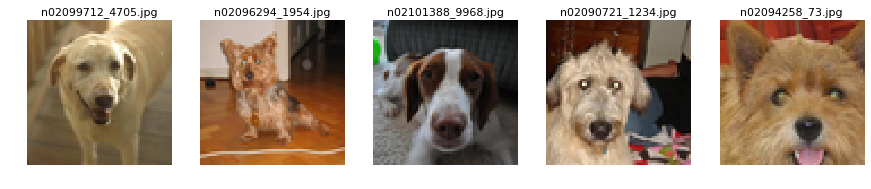

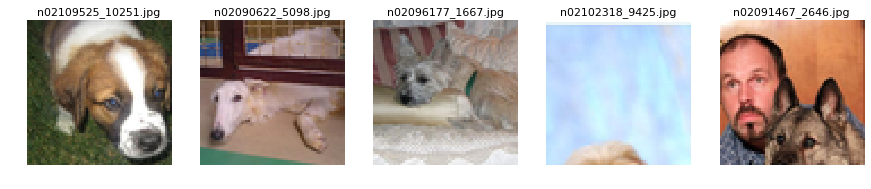

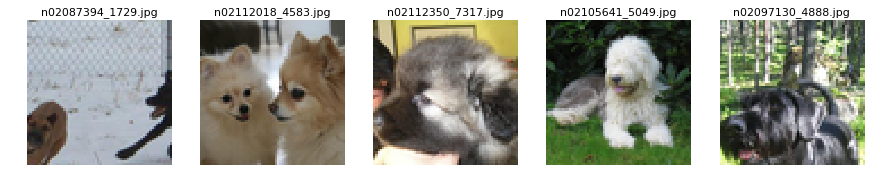

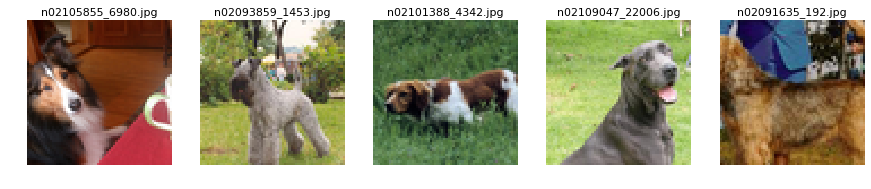

In [3]:
ComputeLB = False
DogsOnly = False

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '../input/generative-dog-images/'
if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    IMAGES = np.sort(IMAGES)
    np.random.seed(810)
    x = np.random.choice(np.arange(20579),10000)
    np.random.seed(None)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))    
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        #if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

# Variables used

In [4]:
IMG_SIZE = Input((12288,))
IMG_SIZE_2 = Input((10000,))
NOISE_SIZE = 10000
BATCH_SIZE = 256

# Build Discriminator

In [5]:
def discriminatorFunction():
    
    input_layer = Dense(12288, activation='sigmoid')(IMG_SIZE_2) 
    input_layer = Reshape((2,12288,1))(concatenate([IMG_SIZE,input_layer]))
    discriminator = Conv2D(filters = 1, kernel_size=[2,1],use_bias=False, name = 'layer_1')(input_layer)
    out = Flatten()(discriminator)
    return out

In [6]:
print("Discriminator")
model = discriminatorFunction()
model_discriminator = Model([IMG_SIZE,IMG_SIZE_2], model)
model_discriminator.get_layer('layer_1').trainable = False
model_discriminator.get_layer('layer_1').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
model_discriminator.summary()
model_discriminator.compile(optimizer='SGD', loss='binary_crossentropy')

Discriminator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12288)        122892288   input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24576)        0           input_1[0][0]                    
                                                                 dense_1[0][0]                 

# Build Generator

In [7]:
def GeneratorFunction(noise_shape=(NOISE_SIZE,)):
    input_layer = Input(noise_shape)
    generated = Dense(12288, activation='linear')(input_layer)
        
# COMPILE
    model = Model(inputs=input_layer,outputs = [generated,Reshape((10000,))(input_layer)])
    model.summary()
  
    return model

In [8]:
print("Generator")
model_generator = GeneratorFunction(noise_shape=(NOISE_SIZE,))

Generator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12288)        122892288   input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 10000)        0           input_3[0][0]                    
Total params: 122,892,288
Trainable params: 122,892,288
Non-trainable params: 0
__________________________________________________________________________________________________


# Train the Discriminator

In [9]:
# TRAINING DATA
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

# ---------------------
#  Train Discriminator
# ---------------------

lr = 0.5
for k in range(8):
    LR_Scheduler = LearningRateScheduler(lambda x: lr)
    h = model_discriminator.fit([zeros,train_X], train_y, epochs = 100,batch_size = BATCH_SIZE, callbacks=[LR_Scheduler], verbose=0)
    print('Epoch',(k+1)*10,'/50 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /50 - loss = 0.6923647953033447
Epoch 20 /50 - loss = 0.6916286240577698
Epoch 30 /50 - loss = 0.6909503280639648
Epoch 40 /50 - loss = 0.6903245906829834
Epoch 50 /50 - loss = 0.6897475126266479
Epoch 60 /50 - loss = 0.6892167171478272
Epoch 70 /50 - loss = 0.6887263813972473
Epoch 80 /50 - loss = 0.6882748119354248


In [10]:
del train_X, train_y, imagesIn

Discriminator Recalls from Memory Dogs


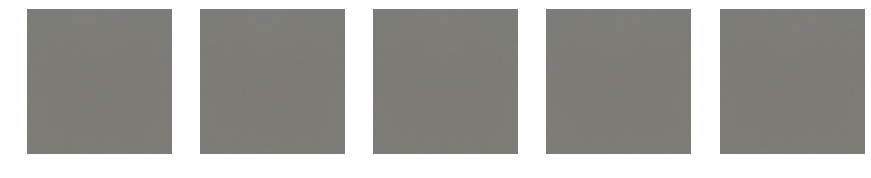

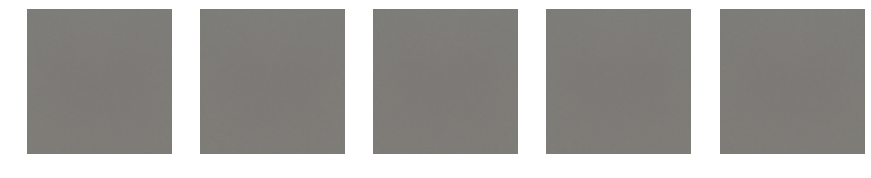

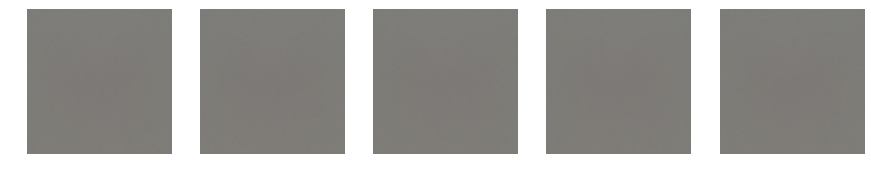

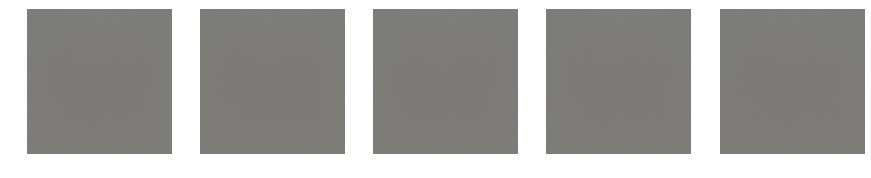

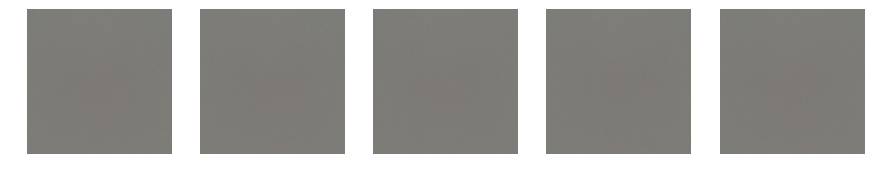

In [11]:
print('Discriminator Recalls from Memory Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = model_discriminator.predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,10000))]).reshape((-1,64,64,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Build the GAN

In [12]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
model_discriminator.trainable = False #discriminator is not trainable for GANs
z = Input(shape=(NOISE_SIZE,))
img = model_generator(z)
real = model_discriminator(img)

# COMPILE GAN
gan = Model(z, real)
gan.get_layer('model_1').get_layer('layer_1').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
print("Model created based on Discriminator and Generator")
gan.summary()

Model created based on Discriminator and Generator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 12288), (Non 122892288   input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        122892290   model_2[1][0]                    
                                                                 model_2[1][1]                    
Total params: 245,784,578
Trainable params: 122,892,288
Non-trainable params: 122,892,290
___________________________________________________________________

# Train the GAN

In [13]:
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

Steps_per_epoch = 50

print("Training begins... Total steps per epoch: {}".format(Steps_per_epoch ))


Training begins... Total steps per epoch: 50


Step: 10/500 [G loss: 3546.5539]


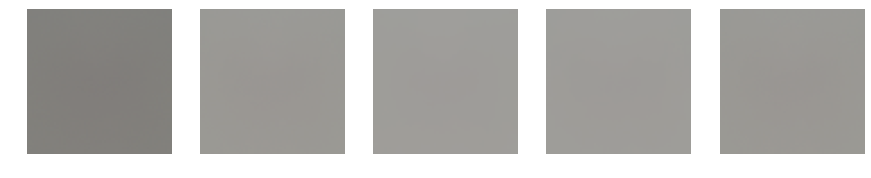

Step: 20/500 [G loss: 428.9460]


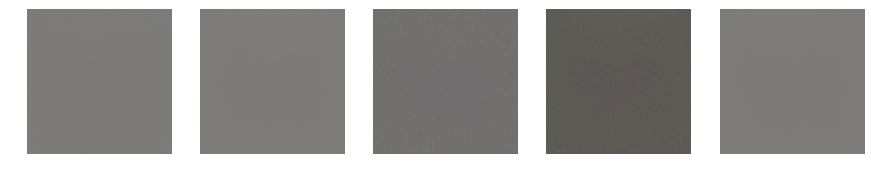

Step: 30/500 [G loss: 165.1203]


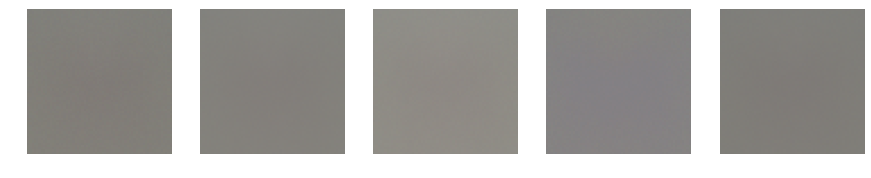

Step: 40/500 [G loss: 56.8463]


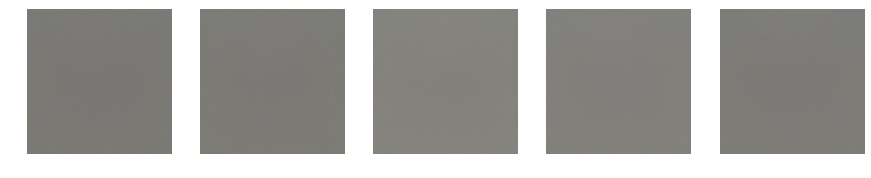

Step: 50/500 [G loss: 42.0930]


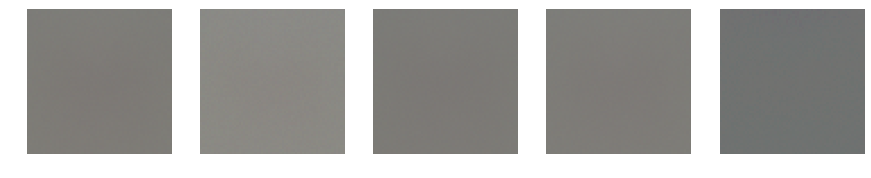

Step: 60/500 [G loss: 37.5348]


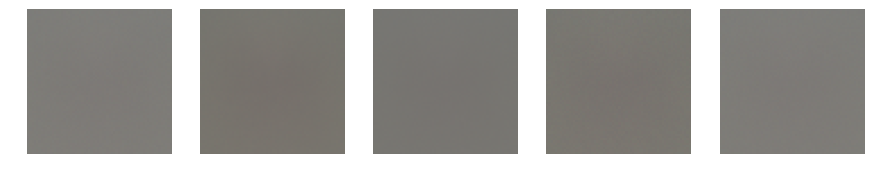

Step: 70/500 [G loss: 37.0261]


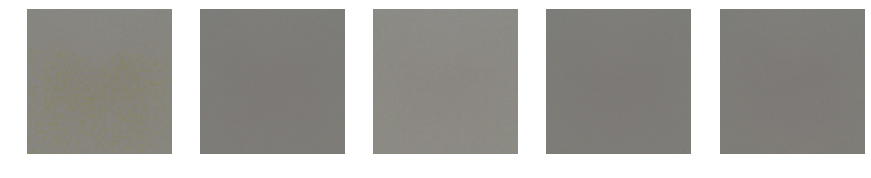

Step: 80/500 [G loss: 37.9599]


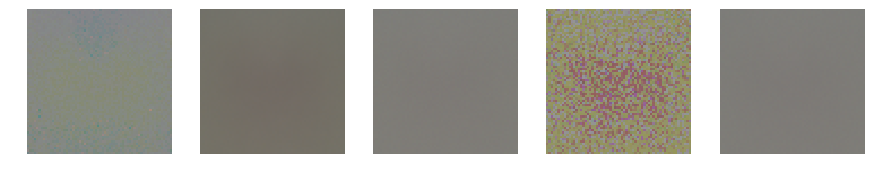

Step: 90/500 [G loss: 39.0994]


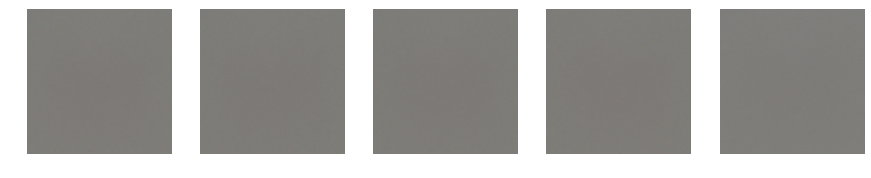

Step: 100/500 [G loss: 42.5209]


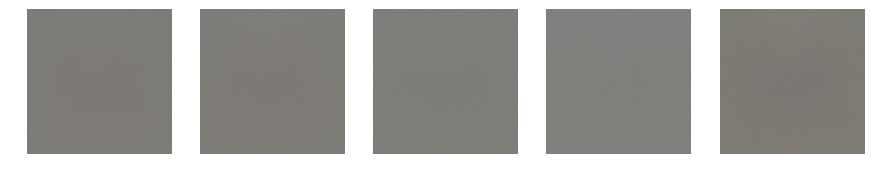

Step: 150/500 [G loss: 97.0197]
Step: 200/500 [G loss: 174.9332]
Step: 250/500 [G loss: 150.2789]
Step: 300/500 [G loss: 134.4047]
Step: 350/500 [G loss: 153.8335]
Step: 400/500 [G loss: 195.0510]
Step: 450/500 [G loss: 219.3388]
Step: 500/500 [G loss: 209.5983]


In [14]:
warnings.filterwarnings("ignore")

lr = 5.

for step in range(Steps_per_epoch):
        
    # ---------------------
    #  Train GAN
    # ---------------------
    LR_Scheduler = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = 1, batch_size=256, callbacks=[LR_Scheduler], verbose=0)

    # DISPLAY GENERATOR LEARNING PROGRESS 
    if (step<10)|(step%5==4):
        
        print ("Step: {}/{} [G loss: {:.4f}]".format(
                     (step+1)*10, Steps_per_epoch*10, h.history['loss'][-1]))
        
    if h.history['loss'][-1] < 25: lr = 1.
    if h.history['loss'][-1] < 1.5: lr = 0.5
        
    # DISPLAY GENERATOR LEARNING PROGRESS
    
    if step<10: 
    
        # Plot images
        plt.figure(figsize=(15,3))
        for j in range(5):
            zz = np.zeros((10000))
            zz[np.random.randint(10000)] = 1
            plt.subplot(1,5,j+1)
            img = model_generator.predict(zz.reshape((-1,10000)))[0].reshape((-1,64,64,3))
            img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
            plt.axis('off')
            plt.imshow(img)
        plt.show()   

# Submit to Kaggle

In [15]:
class DogGenerator:
    index = 0   
    def getDog(self,seed):
        xx = np.zeros((10000))
        xx[self.index] = 0.999
        xx[np.random.randint(10000)] = 0.001
        img = model_generator.predict(xx.reshape((-1,10000)))[0].reshape((64,64,3))
        self.index = (self.index+1)%10000
        return Image.fromarray( img.astype('uint8') ) 

In [16]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
d = DogGenerator()
for k in range(10000):
    img = d.getDog(np.random.normal(0,1,100))
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()